# NBA MVP Vorhersage – End-to-End Machine Learning Projekt

In diesem Projekt entwickeln wir ein Machine-Learning-Modell, um vorherzusagen, welcher Spieler in der NBA den Most Valuable Player (MVP) Award gewinnen wird. Dafür nutzen wir historische Spieler- und Teamstatistiken als Datengrundlage, aus denen wir relevante Merkmale (**Features**) extrahieren und verarbeiten.

---

## Problemstellung

Da pro NBA-Saison genau ein Spieler zum MVP gewählt wird, handelt es sich hierbei um ein **Klassifikationsproblem mit einer sehr starken Klassenungleichverteilung (Imbalance)**:

* **Problemtyp:**
    * Primär eine **binäre Klassifikation** pro Spieler und Saison („MVP“ vs. „Nicht-MVP“).
    * Alternativ kann man es auch als **Multi-Klassen-Klassifikation** betrachten (1 MVP vs. viele Nicht-MVPs pro Saison).
* **Klassenverteilung:** Extrem unausgeglichen, da pro Saison nur genau ein Spieler als MVP ausgezeichnet wird und viele weitere Spieler diese Auszeichnung nicht erhalten.

---

## Zielmetriken

Um die Modelle trotz der unausgeglichenen Daten effektiv zu bewerten, verwenden wir spezielle Metriken, die für solche Szenarien geeignet sind:

* **Precision:** Der Anteil der korrekt als MVP klassifizierten Spieler an allen Spielern, die das Modell als MVP vorhergesagt hat.
* **Recall:** Der Anteil der korrekt als MVP vorhergesagten Spieler am tatsächlich gewählten MVP.
* **F1-Score:** Das harmonische Mittel von Precision und Recall. Er bietet einen Ausgleich zwischen beiden Metriken und ist besonders nützlich bei unausgeglichenen Klassen.
* **ROC-AUC (Receiver Operating Characteristic - Area Under the Curve):** Eine Metrik, die unabhängig von einem Schwellenwert die Gesamtqualität der Modellvorhersagen bewertet. Ein höherer AUC-Wert deutet auf eine bessere Trennung zwischen den Klassen hin.

Diese Metriken stellen sicher, dass unser Modell sowohl präzise als auch robust auf die starke Klassenungleichverteilung reagiert und valide Vorhersagen liefert.

Für die Erstellung und Optimierung der Modelle wurde unterstützend auf Künstliche Intelligenz (AI), insbesondere für Feature Engineering und Modelloptimierung, zurückgegriffen.

Die methodische Herangehensweise und Logik orientieren sich stark an den Vorlesungsunterlagen sowie der empfohlenen Literatur des Moduls „AI Applications“. Insbesondere die Konzepte zur Datenvorbereitung, Modellselektion und Hyperparameter-Tuning aus „Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow“ von Aurélien Géron wurden angewandt.

## Pakete installieren

In [1]:
# Datenmanipulation
import pandas as pd
import numpy as np

# Visualisierung
import matplotlib.pyplot as plt
import seaborn as sns

# XGBoost
import xgboost as xgb
from xgboost import XGBClassifier

# Machine Learning – Modelle & Tools
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve

# Optional – Web Scraping & API
import requests
from bs4 import BeautifulSoup

# Hugging Face Deployment
from huggingface_hub import InferenceClient, login

# Jupyter spezifisch (für Plot-Darstellung inline)
%matplotlib inline


## 1. Datenakquise & Datenstruktur

Für dieses Projekt wurden die Daten manuell aus zwei Hauptquellen für die **NBA-Saisons 2004/05 bis 2023/24** zusammengeführt:

* **Basketball Reference:** Hier wurden die Informationen zur **MVP-Auszeichnung** (Spieler, Team, Saison) gesammelt.
* **Stathead:** Diese Quelle lieferte detaillierte Statistiken:
    * **Team Win%** (Siegquote in der Regular Season)
    * Die **Top 200 Spieler nach Win Shares**, inklusive Basis-Stats wie **PPG** (Punkte pro Spiel), **RPG** (Rebounds pro Spiel) und **APG** (Assists pro Spiel).
    * **Advanced Stats** wie **ORtg** (Offensiv-Rating), **DRtg** (Defensiv-Rating), **PER** (Player Efficiency Rating), **BPM** (Box Plus/Minus), **USG%** (Usage Percentage) und **VORP** (Value Over Replacement Player).

Als **Tooling** kam Python zum Einsatz, um die Daten mittels CSV-Export oder Web Scraping zu erfassen und in DataFrame-Pipelines zu verarbeiten. Das manuelle Vorgehen ermöglichte eine **vollständige Kontrolle über die Datenqualität und -struktur**.

### MVP Daten (04/05 - 23/24)

Dieses Skript verarbeitet die MVP-Voting-Daten der Saisons 2004/05 bis 2023/24.
Ziel ist es, aus den rohen CSV-Dateien pro Saison einheitliche, saubere Daten im Format
Player, Team, PPG, RPG, APG, Season, MVP (1/0) zu extrahieren.

❌ Keine gültigen MVP-Daten geladen.


### Spielerstatistiken & Win Shares (2004/05 – 2023/24)

Dieses Skript verarbeitet Spielerstatistiken und Win Shares für alle NBA-Saisons von **2004/05 bis 2023/24**.

#### Berechnungen:

* **PPG** (Punkte pro Spiel) = `PTS` / `G`
* **APG** (Assists pro Spiel) = `AST` / `G`
* **RPG** (Rebounds pro Spiel) = `TRB` / `G`

#### Zielstruktur:

Die resultierenden Daten umfassen folgende Spalten:

* `Player` (Spielername)
* `Team` (Teamzugehörigkeit)
* `Season` (Saison)
* `PPG`
* `RPG`
* `APG`
* `WS` (Win Shares)

#### Hinweise:

* Es werden ausschliesslich gültige Zeilen berücksichtigt, die einen numerischen Wert für die Anzahl der Spiele (`G`) aufweisen.
* Die Teamzugehörigkeit sowie die Win Shares werden ebenfalls erfasst und als wichtige Features gespeichert.
* Alle pro-Spiel-Werte (PPG, RPG, APG) werden auf eine Nachkommastelle gerundet.

In [ ]:
import os
import glob
import pandas as pd

# Pfad zum Win Shares Ordner definieren
base_path = "data_dirty/winshares"
winshare_files = glob.glob(os.path.join(base_path, "*.csv"))

# Liste zum Sammeln der bereinigten DataFrames
ws_dfs = []

# Jede Datei laden, berechnen und vorbereiten
for file in winshare_files:
    try:
        # Saison aus Dateinamen extrahieren
        season = os.path.splitext(os.path.basename(file))[0].split("_")[-2] + "/" + os.path.splitext(os.path.basename(file))[0].split("_")[-1]

        # CSV laden (Header optional anpassen je nach Format)
        df = pd.read_csv(file, sep=";", encoding="utf-8", header=None)

        # Nur Zeilen mit gültigen Spielanzahlen (G) behalten
        df = df[df[6].apply(lambda x: str(x).replace('.', '', 1).isdigit())]

        # Werte extrahieren und berechnen
        df_clean = pd.DataFrame({
            "Player": df[1],
            "Team": df[5],
            "PTS": df[26].astype(float),
            "TRB": df[20].astype(float),
            "AST": df[21].astype(float),
            "G": df[6].astype(float),
            "WS": df[2].astype(float),
            "Season": season
        })

        
        # Pro-Spiel Metriken berechnen
        df_clean["PPG"] = (df_clean["PTS"] / df_clean["G"]).round(1)
        df_clean["RPG"] = (df_clean["TRB"] / df_clean["G"]).round(1)
        df_clean["APG"] = (df_clean["AST"] / df_clean["G"]).round(1)
        # Finale Spaltenstruktur
        df_final = df_clean[["Player", "Team", "Season", "PPG", "RPG", "APG", "WS"]]

        ws_dfs.append(df_final)

    except Exception as e:
        print(f"Fehler in Datei {file}: {e}")

# Zusammenführen und speichern
if ws_dfs:
    df_ws_final = pd.concat(ws_dfs, ignore_index=True)
    os.makedirs("data_clean", exist_ok=True)
    df_ws_final.to_csv("data_clean/winshares_final.csv", index=False)
    print("Win Shares gespeichert: data_clean/winshares_final.csv")
else:
    print("Keine gültigen Win Shares-Dateien gefunden.")


✅ Win Shares gespeichert: data_clean/winshares_final.csv


### Team Stats (04/05 - 23/24)
Hier verarbeiten wir die Team-Siegquoten von 2004/05 bis 2023/24.
Ziel ist es, aus jeder CSV-Datei die Teamnamen und die Win Percentage (W/L%) auszulesen
und mit der jeweiligen Saison in einem einheitlichen DataFrame zu speichern.

In [1]:
# Pfad zum Team-Winrate-Ordner definieren
base_path = "data_dirty/team_winrates"
team_files = glob.glob(os.path.join(base_path, "*.csv"))

# Liste zum Sammeln der bereinigten DataFrames
team_dfs = []

# Jede Datei einlesen und vorbereiten
for file in team_files:
    try:
        # Saison extrahieren
        season = os.path.splitext(os.path.basename(file))[0].split("_")[-2] + "/" + os.path.splitext(os.path.basename(file))[0].split("_")[-1]

        # CSV einlesen – mit Header ab Zeile 1
        df = pd.read_csv(file, sep=";", encoding="utf-8", header=0)

        # Nur Teams und Win Percentage extrahieren
        df_clean = pd.DataFrame({
            "Team": df["Team"],
            "Win%": df["W/L%"],
            "Season": season
        })

        team_dfs.append(df_clean)

    except Exception as e:
        print(f"Fehler in Datei {file}: {e}")

# Gesamten Team-Winrate-Datensatz zusammenfügen und speichern
if team_dfs:
    df_teams_final = pd.concat(team_dfs, ignore_index=True)
    os.makedirs("data_clean", exist_ok=True)
    df_teams_final.to_csv("data_clean/team_winrate_final.csv", index=False)
    print("Team-Winrate-Daten gespeichert unter: data_clean/team_winrate_final.csv")
else:
    print("Keine gültigen Team-Winrate-Dateien gefunden.")

NameError: name 'glob' is not defined

### Advanced (04/05 - 23/24)
Hier werden alle CSV-Dateien mit Advanced-Metriken eingelesen, für jede Saison bereinigt und auf relevante Spalten reduziert. Anschliessend werden die Einzeltabellen zu einem konsolidierten DataFrame zusammengeführt und als advanced_stats_final.csv gespeichert.



In [2]:
import os
import glob
import pandas as pd

# 1. Pfad zum Advanced-Stats-Ordner definieren
base_path = "Data/data_dirty/advanced"
adv_files = glob.glob(os.path.join(base_path, "*.csv"))

# Liste zum Sammeln der bereinigten DataFrames
adv_dfs = []

# 2. Jede Datei einlesen und vorbereiten
for file in adv_files:
    try:
        # Saison extrahieren aus Dateiname (z.B. "advanced_23_24.csv")
        fname = os.path.splitext(os.path.basename(file))[0].split("_")
        season = f"{fname[-2]}/{fname[-1]}"

        # CSV einlesen – mit Header ab Zeile 0 (angepasst an dein Format)
        df = pd.read_csv(file, sep=";", encoding="utf-8", header=0)

        # Nur relevante Spalten extrahieren und Season hinzufügen
        df_clean = pd.DataFrame({
            "Player": df["Player"],
            "Team": df["Team"],
            "Season": season,
            "ORtg": df["ORtg"],
            "DRtg": df["DRtg"],
            "PER": df["PER"],
            "BPM": df["BPM"],
            "USG%": df["USG%"],
            "VORP": df["VORP"]
        })

        adv_dfs.append(df_clean)

    except Exception as e:
        print(f"Fehler in Datei {file}: {e}")

# 3. Gesamten Advanced-Stats-Datensatz zusammenfügen und speichern
if adv_dfs:
    df_adv_final = pd.concat(adv_dfs, ignore_index=True)
    os.makedirs("data_clean", exist_ok=True)
    df_adv_final.to_csv("Data/data_clean/advanced_stats_final.csv", index=False)
    print("Advanced Stats-Daten gespeichert unter: data_clean/advanced_stats_final.csv")
else:
    print("Keine gültigen Advanced Stats-Dateien gefunden.")


Keine gültigen Advanced Stats-Dateien gefunden.


## 2. Datenbereinigung & Merge

Schrittweise Bereinigung, Harmonisierung und Zusammenführung der vorbereiteten Datenquellen zu einem finalen Dataset.

**Ziel:** Saubere und konsistente Datenbasis aller Tabellen sicherstellen und zu einem einzigen DataFrame zusammenführen.



In [8]:
# 1. Libraries importieren
import pandas as pd
import os
import glob


df_team      = pd.read_csv("data/data_clean/team_winrate_final.csv")  
df_winshares = pd.read_csv("data/data_clean/winshares_final.csv")     
df_adv       = pd.read_csv("data/data_clean/advanced_stats_final.csv")
df_mvp       = pd.read_csv("data/data_clean/mvp_final.csv")
df_team.rename(columns={"Win%": "WinPct"}, inplace=True)


In [9]:
# 2. Einheitliche Schreibweise & Team-Kürzel normalisieren
team_map = {"SEA":"OKC", "CHO":"CHA", "NOH":"NOP", "NJN":"BRK"}
for df in (df_team, df_winshares, df_adv, df_mvp):
    if "Team" in df.columns:
        df["Team"] = df["Team"].str.upper().str.strip().replace(team_map)
    if "Player" in df.columns:
        df["Player"] = df["Player"].str.strip()
    if "Season" in df.columns:
        df["Season"] = df["Season"].str.strip()


In [10]:
# 3. Duplikate entfernen
df_team      = df_team.drop_duplicates(subset=["Team","Season"])
df_winshares = df_winshares.drop_duplicates(subset=["Player","Season"])
df_adv       = df_adv.drop_duplicates(subset=["Player","Season"])
df_mvp       = df_mvp.drop_duplicates(subset=["Player","Season"])


In [11]:
# 4. Ungültige Teams ausschliessen (Team-Codes länger als 3 Zeichen)
for df in (df_winshares, df_adv):
    df.drop(df[df["Team"].str.len() > 3].index, inplace=True)


In [12]:
# 5. Vorbereitung der Advanced-Stats ohne Team-Spalte
adv_cols = ["Player","Season","ORtg","DRtg","PER","BPM","USG%","VORP"]
df_adv_clean = df_adv[adv_cols]


In [15]:
# 6) Merges mit Safety-Checks
df = df_winshares.merge(df_team, on=["Team","Season"], how="left")
assert df["WinPct"].isna().sum() == 0, "Fehlende WinPct nach Team-Merge!"

df = df.merge(df_adv_clean, on=["Player","Season"], how="left")
print(f"Missing Advanced Stats: {df[['ORtg','PER','VORP']].isna().sum().to_dict()}")

df = df.merge(df_mvp[["Player","Season","MVP"]], on=["Player","Season"], how="left")
assert df.groupby("Season")["MVP"].sum().max() <= 1, "Mehr als ein MVP pro Saison gefunden!"

# 8) MVP-Flag auffüllen und Spalten auswählen
df["MVP"] = df["MVP"].fillna(0).astype(int)
df = df[[
    "Player","Team","Season",
    "PPG","RPG","APG","WinPct","WS","MVP",
    "ORtg","DRtg","PER","BPM","USG%","VORP"
]]

# 9) Fehlende Werte (außer MVP) entfernen
mask = (df["MVP"] == 1) | df.notna().all(axis=1)
df = df[mask].reset_index(drop=True)

# 10) Final speichern
output_path = "data/data_clean/final_dataset_complete.csv"
os.makedirs(os.path.dirname(output_path), exist_ok=True)
df.to_csv(output_path, index=False)
print(f"Finaler Datensatz erstellt mit Shape: {df.shape} und gespeichert in {output_path}")

Missing Advanced Stats: {'ORtg': 0, 'PER': 0, 'VORP': 0}
Finaler Datensatz erstellt mit Shape: (3682, 15) und gespeichert in data/data_clean/final_dataset_complete.csv


In [14]:
print(df.head())

                  Player Team Season   PPG   RPG  APG  WinPct    WS  MVP  \
0           James Harden  HOU  18/19  36.1   6.6  7.5   0.646  15.2    0   
1            Rudy Gobert  UTA  18/19  15.9  12.9  2.0   0.610  14.4    0   
2  Giannis Antetokounmpo  MIL  18/19  27.7  12.5  5.9   0.732  14.4    1   
3         Damian Lillard  POR  18/19  25.8   4.6  6.9   0.646  12.1    0   
4            Paul George  OKC  18/19  28.0   8.2  4.1   0.598  11.9    0   

   ORtg  DRtg   PER   BPM  USG%  VORP  
0   118   108  30.6  11.0  40.5   9.3  
1   133   100  24.6   5.4  17.8   4.8  
2   121    99  30.9  10.4  32.3   7.4  
3   121   112  23.7   6.4  29.3   6.0  
4   116   105  23.3   7.2  29.5   6.6  


## 3. Explorative Datenanalyse (EDA) vor Feature Engineering

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from scipy import stats


df = pd.read_csv("data/final_dataset_complete.csv")
print("Shape:", df.shape)
print("\nDatentypen:\n", df.dtypes)
print("\nKlassenverteilung MVP:\n", df['MVP'].value_counts())

Shape: (3682, 15)

Datentypen:
 Player     object
Team       object
Season     object
PPG       float64
RPG       float64
APG       float64
WinPct    float64
WS        float64
MVP         int64
ORtg        int64
DRtg        int64
PER       float64
BPM       float64
USG%      float64
VORP      float64
dtype: object

Klassenverteilung MVP:
 MVP
0    3662
1      20
Name: count, dtype: int64


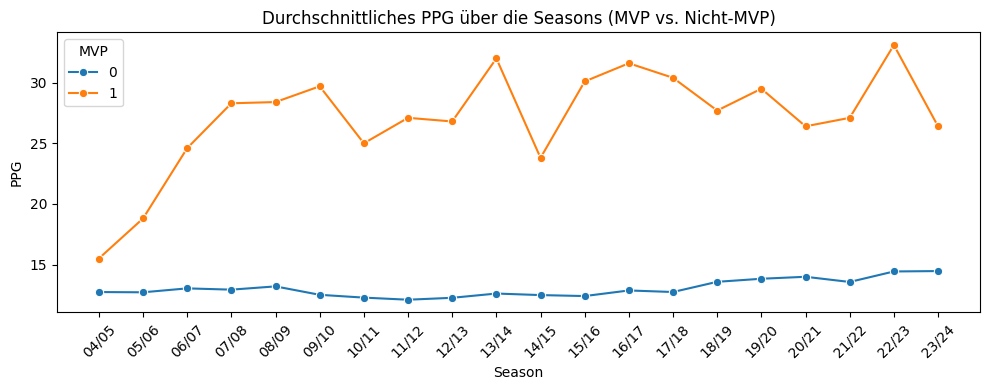

In [44]:
# MVP-Trends über die Jahre
plt.figure(figsize=(10, 4))
sns.lineplot(
    data=df.groupby(['Season','MVP'])['PPG'].mean().reset_index(),
    x='Season', y='PPG', hue='MVP', marker='o'
)
plt.xticks(rotation=45)
plt.title("Durchschnittliches PPG über die Seasons (MVP vs. Nicht-MVP)")
plt.tight_layout()
plt.show()


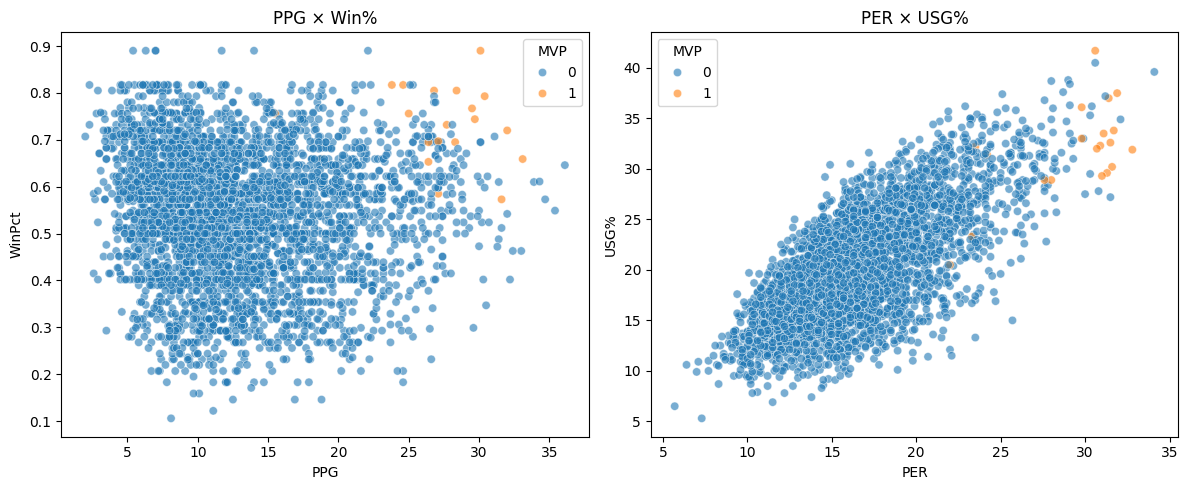

In [45]:
# Feature-Interaktionen als Scatterplots
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.scatterplot(data=df, x='PPG', y='WinPct', hue='MVP', alpha=0.6)
plt.title("PPG × Win%")

plt.subplot(1, 2, 2)
sns.scatterplot(data=df, x='PER', y='USG%', hue='MVP', alpha=0.6)
plt.title("PER × USG%")

plt.tight_layout()
plt.show()

> Takeaway: MVPs zeichnen sich durch eine Kombination aus **herausragenden individuellen Leistungen (hohes PPG, PER, USG%)** und dem **Erfolg ihres Teams (hohes Win%)** aus. Diese Korrelationen sind entscheidend für die Modellbildung.

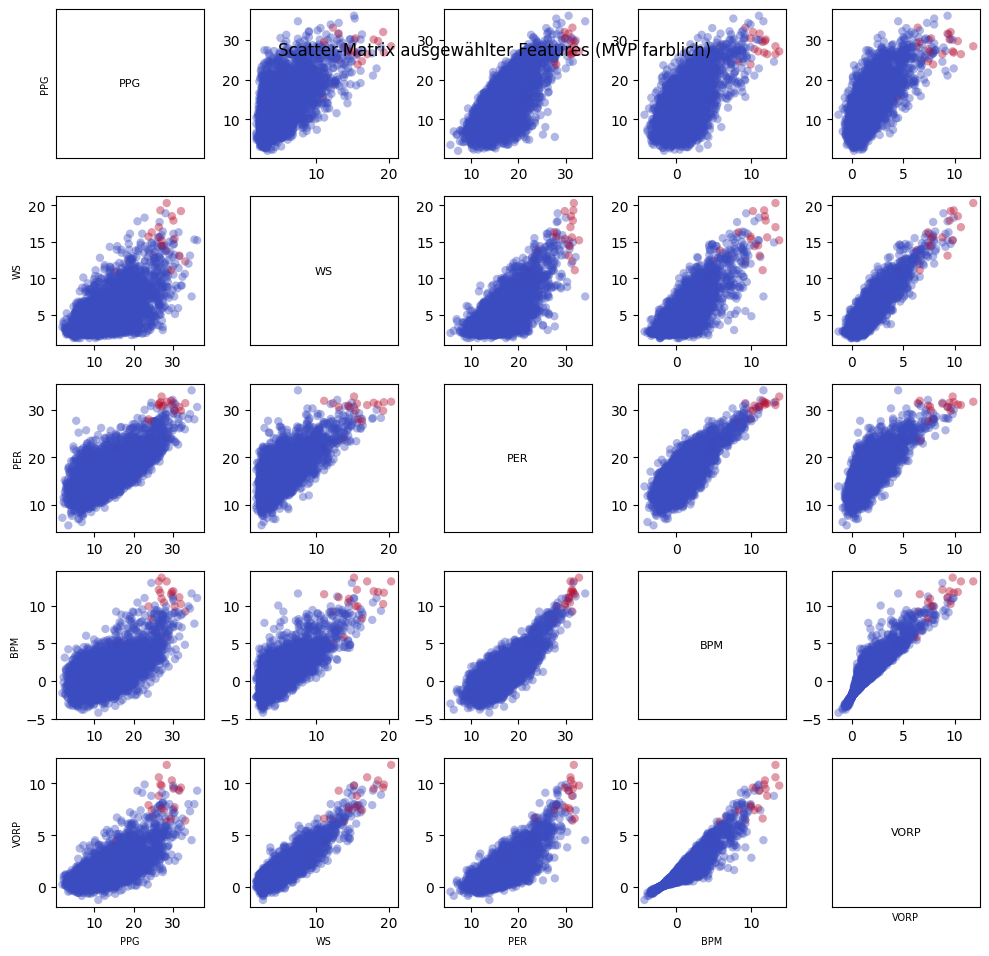

In [46]:
scatter_feats = ['PPG','WS','PER','BPM','VORP']
X = df[scatter_feats]
y = df['MVP']

# Scatter-Matrix plotten
fig, axes = plt.subplots(len(scatter_feats), len(scatter_feats), 
                         figsize=(10, 10), sharex=False, sharey=False)

for i, feat_i in enumerate(scatter_feats):
    for j, feat_j in enumerate(scatter_feats):
        ax = axes[i, j]
        if i == j:
            ax.text(0.5, 0.5, feat_i, ha='center', va='center', fontsize=8)
            ax.set_xticks([])
            ax.set_yticks([])
        else:
            ax.scatter(
                X[feat_j], X[feat_i],
                c=y, cmap='coolwarm',
                alpha=0.4, edgecolors='none'
            )
        if i == len(scatter_feats)-1:
            ax.set_xlabel(feat_j, fontsize=7)
        else:
            ax.set_xlabel('')
        if j == 0:
            ax.set_ylabel(feat_i, fontsize=7)
        else:
            ax.set_ylabel('')

plt.suptitle("Scatter-Matrix ausgewählter Features (MVP farblich)", y=0.92)
plt.tight_layout()
plt.show()


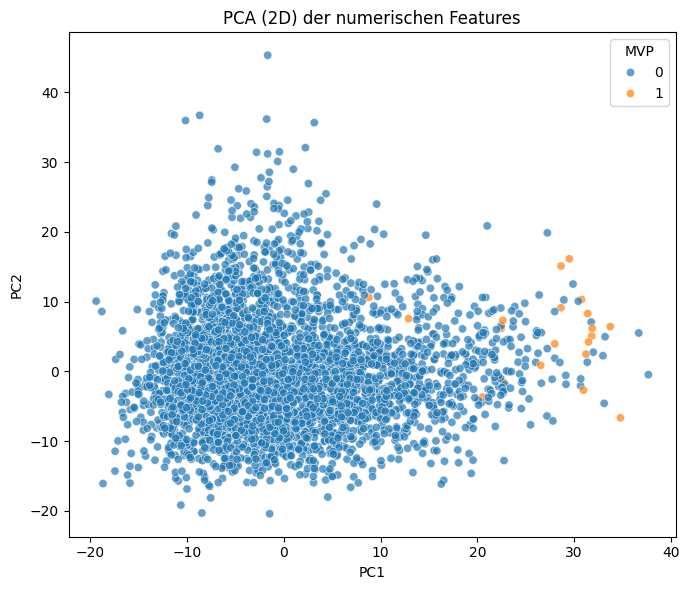

In [47]:
# PCA auf numerischen Features und 2D-Visualisierung
num_feats = ['PPG','RPG','APG','WinPct','WS','ORtg','DRtg','PER','BPM','USG%','VORP']
X = df[num_feats].fillna(0) 
pca2 = PCA(n_components=2)
coords = pca2.fit_transform(X)

pca_df = pd.DataFrame(coords, columns=['PC1','PC2'])
pca_df['MVP'] = df['MVP'].values

plt.figure(figsize=(7, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='MVP', alpha=0.7)
plt.title("PCA (2D) der numerischen Features")
plt.tight_layout()
plt.show()

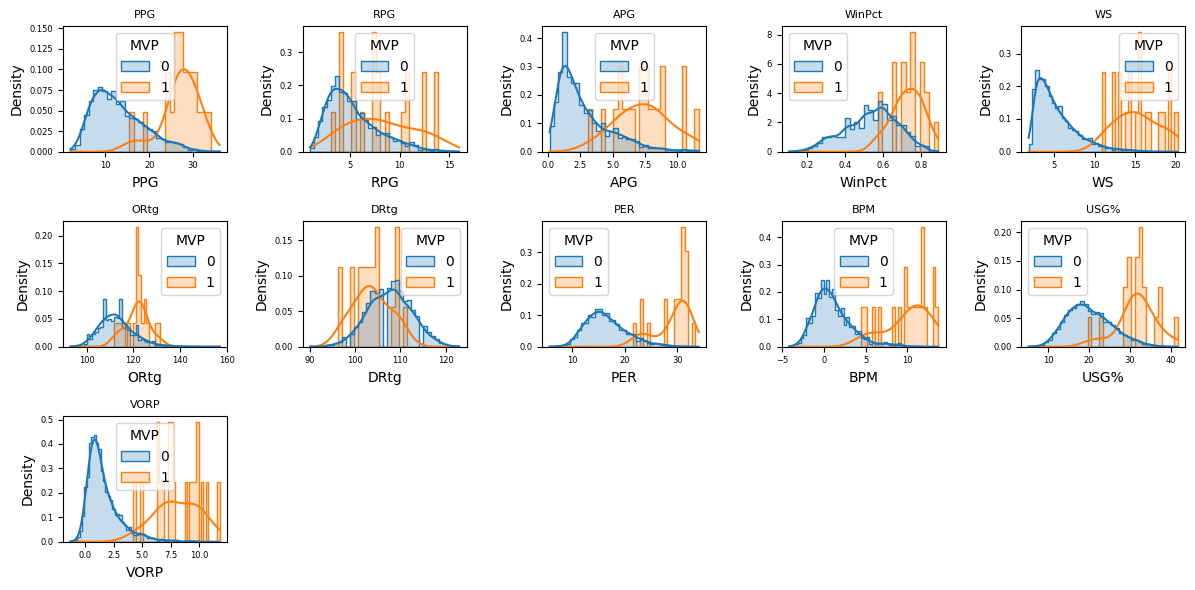

In [48]:
features = [
    'PPG', 'RPG', 'APG', 'WinPct', 'WS',
    'ORtg', 'DRtg', 'PER', 'BPM', 'USG%', 'VORP'
]

# Subplots konfigurieren (kleineres Format)
n_cols = 5
n_rows = math.ceil(len(features) / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 6), sharey=False)

for ax, feat in zip(axes.flatten(), features):
    sns.histplot(
        data=df,
        x=feat,
        hue='MVP',
        element='step',
        stat='density',
        common_norm=False,
        kde=True,
        ax=ax
    )
    ax.set_title(feat, fontsize=8)
    ax.tick_params(labelsize=6)

# Leere Subplots ausblenden
for ax in axes.flatten()[len(features):]:
    fig.delaxes(ax)

plt.tight_layout()
plt.show()

> Takeaway Die Verteilungsplots zeigen, dass MVPs in fast allen Schlüsselstatistiken (besonders **Win%, WS, PER, BPM, VORP**) signifikant höhere Werte aufweisen als Nicht-MVPs, was ihre herausragende individuelle Leistung und ihren Beitrag zum Teamerfolg hervorhebt.

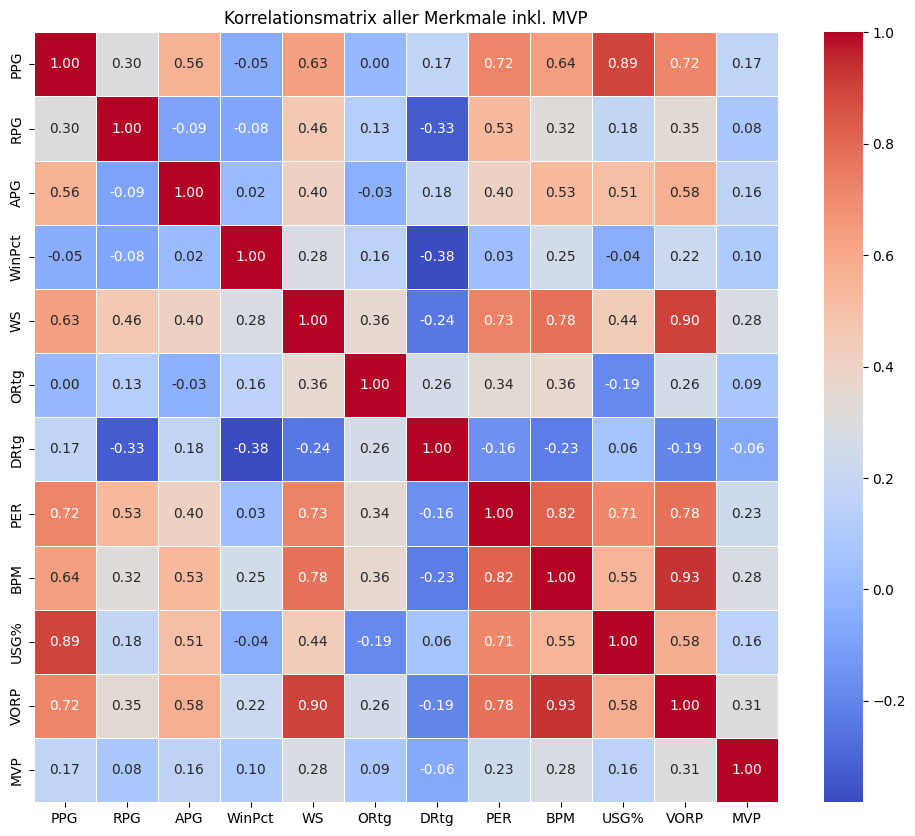

In [49]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# Korrelationsmatrix berechnen
corr_matrix = df[num_feats + ['MVP']].corr()

# Heatmap plotten
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Korrelationsmatrix aller Merkmale inkl. MVP")
plt.show()

> Takeaway Die Korrelationsmatrix zeigt, dass **`VORP`, `WS` und `BPM` die stärksten positiven linearen Korrelationen mit dem MVP-Status aufweisen**, was diese zu den wichtigsten Prädiktoren macht. Eine hohe Multikollinearität zwischen vielen fortgeschrittenen Statistiken ist vorhanden und sollte bei der Modellauswahl berücksichtigt werden.

In [50]:
import pandas as pd

df = pd.read_csv("data/final_dataset_complete.csv")
num_cols = df.select_dtypes(include=['float64', 'int64']).columns.drop('MVP').tolist()
print("Numerische Spalten:", num_cols)

Numerische Spalten: ['PPG', 'RPG', 'APG', 'WinPct', 'WS', 'ORtg', 'DRtg', 'PER', 'BPM', 'USG%', 'VORP']


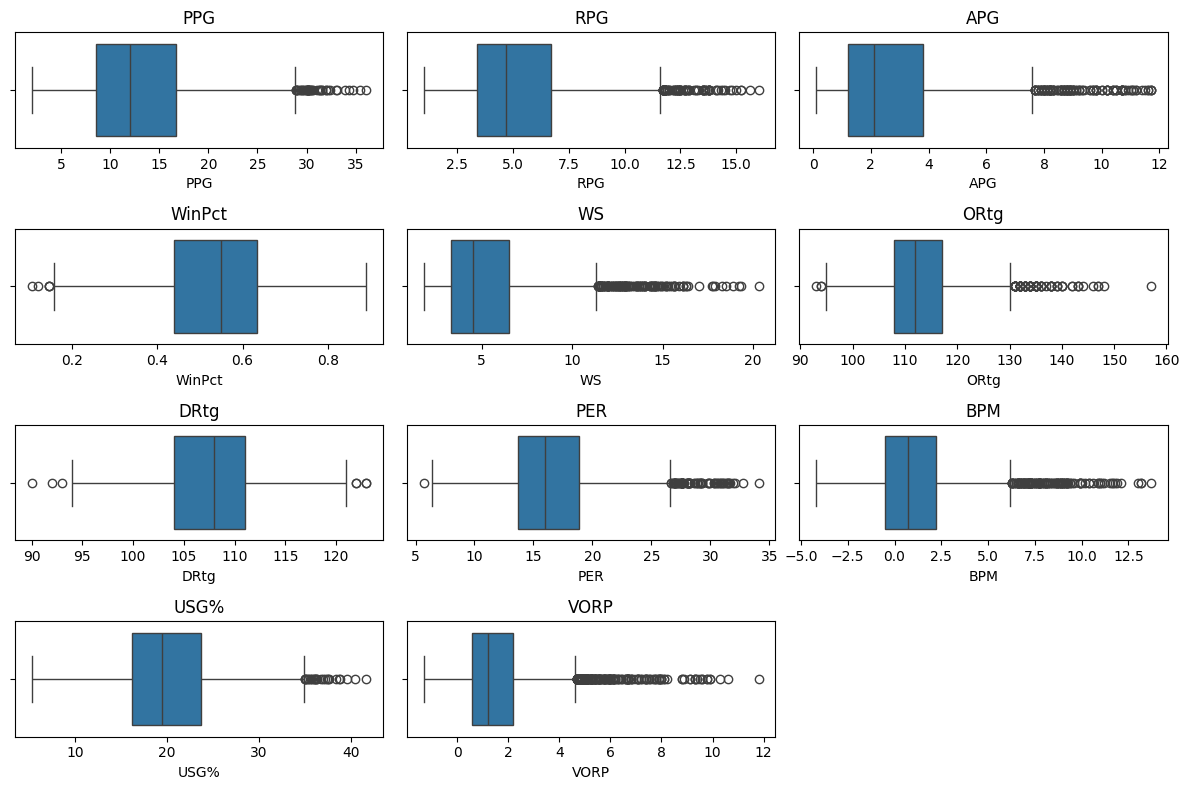

In [51]:
# Boxplots zur visuellen Inspektion von Ausreissern
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
for i, col in enumerate(num_cols, 1):
    plt.subplot(4, 3, i)
    sns.boxplot(x=df[col])
    plt.title(col)
plt.tight_layout()
plt.show()


> Takeaway: Die Boxplots veranschaulichen die Verteilungsbreite der Features und zeigen deutlich, dass MVPs typischerweise zu den **Ausreissern am oberen Ende der Skala** für die meisten relevanten Statistiken gehören, insbesondere bei Werten, die den Gesamteinfluss (WS, PER, BPM, VORP) und die primäre Produktion (PPG, APG) messen.

In [52]:
# Numerische Übersicht & Quantile-Check
num_feats = ['PPG','RPG','APG','WinPct','WS','ORtg','DRtg','PER','BPM','USG%','VORP']
# Standard-Deskriptive Statistik
print(df[num_feats].describe().T)

# Wichtige Quantile für Ausreißer-Einschätzung
quantiles = df[num_feats].quantile([0.01,0.05,0.95,0.99]).T
print("\n1%,5%,95%,99% Quantile:\n", quantiles)

         count        mean       std     min      25%      50%      75%  \
PPG     3682.0   13.106274  5.949944   2.000    8.600   12.000   16.700   
RPG     3682.0    5.296469  2.556564   1.000    3.400    4.700    6.700   
APG     3682.0    2.793400  2.108991   0.100    1.200    2.100    3.800   
WinPct  3682.0    0.537964  0.137958   0.106    0.439    0.549    0.634   
WS      3682.0    5.272868  2.672943   1.800    3.300    4.500    6.500   
ORtg    3682.0  112.843835  7.494220  93.000  108.000  112.000  117.000   
DRtg    3682.0  107.603476  4.839872  90.000  104.000  108.000  111.000   
PER     3682.0   16.559967  4.053962   5.700   13.700   16.000   18.900   
BPM     3682.0    1.082510  2.384451  -4.200   -0.500    0.700    2.200   
USG%    3682.0   20.179413  5.494234   5.300   16.200   19.500   23.700   
VORP    3682.0    1.633161  1.545649  -1.300    0.600    1.200    2.200   

           max  
PPG      36.10  
RPG      16.00  
APG      11.70  
WinPct    0.89  
WS       20.30

In [53]:
# Outlier-Flag für Nicht-MVPs (IQR + Z-Score)
df['is_outlier'] = False
for col in num_feats:
    # IQR-Basiertes Flag
    non_mvp = df['MVP']==0
    Q1 = df.loc[non_mvp, col].quantile(0.25)
    Q3 = df.loc[non_mvp, col].quantile(0.75)
    IQR = Q3 - Q1
    mask_iqr = ((df[col] < Q1-1.5*IQR) | (df[col] > Q3+1.5*IQR)) & non_mvp
    df.loc[mask_iqr, 'is_outlier'] = True

    # Z-Score-Basierte Ergänzung
    z_scores = np.abs(stats.zscore(df.loc[non_mvp, col].fillna(df[col].median())))
    mask_z   = (z_scores > 3)
    df.loc[df.loc[non_mvp].index[mask_z], 'is_outlier'] = True

print("Anzahl markierter Ausreißer (ohne MVPs):", df['is_outlier'].sum())

Anzahl markierter Ausreißer (ohne MVPs): 462


### Warum sehen die Daten nun anders aus? (Effekt des RobustScalers)

Nach der Anwendung des **RobustScaler** auf alle numerischen Features sind die ursprünglichen Werte (z. B. Punkte pro Spiel, Ratings) nicht mehr direkt erkennbar. Das liegt an seiner Funktionsweise:

1.  **Zentrierung am Median:** Jeder Wert $x$ einer Spalte wird um den Median dieser Spalte verschoben: $x_{\text{zentriert}} = x - \mathrm{Median}(x)$.
2.  **Skalierung mit dem Interquartilsabstand (IQR):** Anschliessend wird durch den IQR (75 %–25 % Quantil) geteilt: $x_{\text{skaliert}} = \frac{x_{\text{zentriert}}}{\mathrm{IQR}(x)}$.
    *Der IQR ist weniger anfällig für Ausreisser als die Standardabweichung, daher bleiben die jetzt skalierten Werte hauptsächlich im Bereich $[-3, +3]$, selbst wenn im Original extreme Ausreisser vorhanden waren.*

**Vorteile für das Modell:**

* **Robustheit gegen Ausreisser:** Einzelne Extremwerte dominieren den Massstab nicht mehr.
* **Gleiche Grössenordnung:** Alle Features liegen auf vergleichbarer Skala und erleichtern vielen ML-Algorithmen die effiziente und stabile Konvergenz.

**Spalte `is_outlier`:**

Diese Boolean-Spalte wurde zusätzlich beim Cleaning erstellt und kennzeichnet nur bei Nicht-MVP-Zeilen (`MVP == 0`), welche Einträge per IQR- und Z-Score-Regel als Ausreisser markiert wurden.


---
unten nicht beachten, hier wurden Ausreisser entfernt

In [35]:
# Nur Nicht-MVP-Ausreißer herausfiltern
to_drop = df.index[outlier_mask & (df['MVP'] == 0)]

In [37]:
removed = df.loc[to_drop, ['Player','Team','Season'] + num_cols + ['MVP']]
print(f"Entferne {len(to_drop)} Ausreißer-Zeilen (ohne MVPs):\n")
print(removed)

Entferne 224 Ausreißer-Zeilen (ohne MVPs):

                Player Team Season   PPG   RPG  APG   Win%   WS  ORtg  DRtg  \
7          Mike Conley  MEM  18/19  21.1   3.4  6.4  0.402  8.0   117   111   
11        Bradley Beal  WAS  18/19  25.6   5.0  5.5  0.390  7.6   113   114   
14        Kemba Walker  CHO  18/19  25.6   4.4  5.9  0.476  7.4   112   114   
25    Hassan Whiteside  MIA  18/19  12.3  11.3  0.8  0.476  6.3   112    99   
42        De'Aaron Fox  SAC  18/19  17.3   3.8  7.3  0.476  5.6   110   111   
...                ...  ...    ...   ...   ...  ...    ...  ...   ...   ...   
3083        Marc Gasol  MEM  16/17  19.5   6.3  4.6  0.524  7.7   111   106   
3098        Kevin Love  CLE  16/17  19.0  11.1  1.9  0.622  6.4   114   107   
3148    Tyson Chandler  PHO  16/17   8.4  11.5  0.6  0.293  4.1   129   109   
3158      Jrue Holiday  NOP  16/17  15.4   3.9  7.3  0.415  3.8   104   108   
3173      JaVale McGee  GSW  16/17   6.1   3.2  0.2  0.817  3.5   120   101   

       

In [1]:
# 5 Nur Nicht-MVP-Ausreisser entfernen
to_drop = df.index[outlier_mask & (df['MVP'] == 0)]
print(f"Entferne {len(to_drop)} Ausreisser-Zeilen (ohne MVPs).")

df_clean = df.drop(index=to_drop).reset_index(drop=True)

# 6. Bereinigten Datensatz speichern
df_clean.to_csv("data/cleaned_final_dataset.csv", index=False)
print("Bereinigte Datei gespeichert als data/final_dataset.csv")

NameError: name 'df' is not defined

---

In [45]:
import pandas as pd

# Datensatz einlesen
df = pd.read_csv("data/final_dataset_with_outlier.csv")

# Anzahl der MVPs zählen (MVP == 1)
num_mvp = df['MVP'].sum()

print(f"Anzahl der MVP-Einträge im Datensatz: {int(num_mvp)}")


Anzahl der MVP-Einträge im Datensatz: 20


### 3.4 Erkenntnisse aus der Explorativen Datenanalyse (EDA)






---

## 4. Feature Engineering – Zusammenfassung & Bewertung

In diesem Kapitel haben wir die Rohdaten systematisch aufbereitet und neue Merkmale erzeugt, um unserem Klassifikator maximales Signal bei minimalem Rauschen zu liefern:

1. **Typ- und Qualitätssicherung**  
   - Numerische Spalten (`PPG`, `RPG`, `APG`, `Win%`, `WS`, `ORtg`, `DRtg`, `PER`, `BPM`, `USG%`, `VORP`) in `float64` konvertiert  
   - Kategorische Spalten (`Team`, `Season`) als `category` markiert  

2. **Neue, koordinierte Features**  
   - **Team-Kontext**:  
     - `Standings` (Rangplatz pro Saison)  
     - `Top3_Team` (Binärindikator für Top 3)  
   - **Leistungs-Interaktionen**:  
     - `PPG_weighted` = PPG × Win%  
     - `Efficiency_score` = (PPG + RPG + APG) × Win%  
     - `BPM_x_USG%` = BPM × Usage Rate  
     - `PPG_x_Win%` = PPG × Win%  
   - **Relative Metriken**:  
     - `PPG_rel` = PPG / Ligadurchschnitt_PPG  
     - `Net_Rating` = ORtg − DRtg  

3. **Skalierung**  
   - Einsatz von `StandardScaler` für alle numerischen Features, um einheitliche Mittelwerte (0) und Standardabweichungen (1) sicherzustellen.


In [46]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

In [55]:
df = pd.read_csv("data/final_dataset_complete.csv")
print("Before FE:", df.shape)

Before FE: (3682, 15)


### Neue Features erstellen

In [57]:
# Relative Features: Abweichung vom Ligadurchschnitt pro Saison
rel_feats = ['PPG','PER','WS','WinPct']
for feat in rel_feats:
    df[f"{feat}_rel"] = df[feat] - df.groupby('Season')[feat].transform('mean')

In [59]:
# 2. Neues Feature: Standings
df['Standings'] = (
    df.groupby('Season')['WinPct']
      .rank(method='dense', ascending=False)
      .astype(int)
)
df['Top3_Team'] = (df['Standings'] <= 3).astype(int)

In [60]:
#  – PPG gewichtet mit Team-Erfolg
df['PPG_weighted']     = (df['PPG'] * df['WinPct']).round(2)
#  – Kombinierte Efficiency
df['Efficiency_score'] = ((df['PPG'] + df['RPG'] + df['APG']) * df['WinPct']).round(2)
#  – Net Rating (Offense minus Defense)
df['Net_Rating']       = (df['ORtg'] - df['DRtg']).round(2)
#  – BPM × Usage Rate
df['BPM_x_USG']        = (df['BPM'] * df['USG%']).round(2)
#  – PPG × Team-Erfolg (noch einmal separat)
df['PPG_x_WinPct']     = (df['PPG'] * df['WinPct']).round(2)

In [63]:
# 4. Kontrolle der neuen Features
print(df.head()[[
    'Player','Season','MVP',
    'PPG_rel','PER_rel','WS_rel','WinPct_rel',
    'Standings','PPG_weighted','Efficiency_score',
    'Net_Rating','BPM_x_USG','PPG_x_WinPct'
]])

                  Player Season  MVP    PPG_rel    PER_rel    WS_rel  \
0           James Harden  18/19    0  22.440805  13.662069  9.862069   
1            Rudy Gobert  18/19    0   2.240805   7.662069  9.062069   
2  Giannis Antetokounmpo  18/19    1  14.040805  13.962069  9.062069   
3         Damian Lillard  18/19    0  12.140805   6.762069  6.762069   
4            Paul George  18/19    0  14.340805   6.362069  6.562069   

   WinPct_rel  Standings  PPG_weighted  Efficiency_score  Net_Rating  \
0    0.107034          5         23.32             32.43          10   
1    0.071034          7          9.70             18.79          33   
2    0.193034          1         20.28             33.75          22   
3    0.107034          5         16.67             24.10           9   
4    0.059034          8         16.74             24.10          11   

   BPM_x_USG  PPG_x_WinPct  
0     445.50         23.32  
1      96.12          9.70  
2     335.92         20.28  
3     187.52      

In [64]:
# Finalen Datensatz mit neuen Features speichern

output_path = "data/final_dataset_with_features.csv"
df.to_csv(output_path, index=False)
print(f"Feature-Engineered dataset saved: {output_path} (Shape: {df.shape})")

Feature-Engineered dataset saved: data/final_dataset_with_features.csv (Shape: (3682, 26))


In [55]:
# 6. Feature-Liste definieren und skalieren
from sklearn.preprocessing import StandardScaler

final_features = [
    'PPG', 'RPG', 'APG', 'Win%', 'WS',
    'ORtg', 'DRtg', 'PER', 'BPM', 'USG%', 'VORP',
    'PPG_weighted', 'Efficiency_score',
    'Standings', 'Top3_Team', 'PPG_rel', 'Net_Rating', 'BPM_x_USG%', 'PPG_x_Win%'
]

X = df[final_features]
y = df['MVP']

scaler   = StandardScaler()
X_scaled = pd.DataFrame(
    scaler.fit_transform(X),
    columns=final_features
)

### Feature Importance und EDA nach Feature Engineering

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE, SelectFromModel

In [67]:
# Datensatz mit Features einlesen
df = pd.read_csv("data/final_dataset_with_features.csv")
y = df["MVP"]
# Alle numerischen Features außer Label
features = [c for c in df.columns if c not in ["Player","Team","Season","MVP","is_outlier"]]
X = df[features]

In [68]:
# 5.2 Random Forest Feature Importances
rf = RandomForestClassifier(
    n_estimators=200,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)
rf.fit(X, y)
rf_importances = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=False)

print("Top 10 RF Importances:")
print(rf_importances.head(10))

Top 10 RF Importances:
WS_rel              0.153189
Efficiency_score    0.144378
WS                  0.131352
VORP                0.114501
BPM                 0.080779
PER                 0.077986
PPG_x_WinPct        0.073882
BPM_x_USG           0.046858
PER_rel             0.045179
PPG_rel             0.039918
dtype: float64


/tmp/ipykernel_2034/1279435363.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


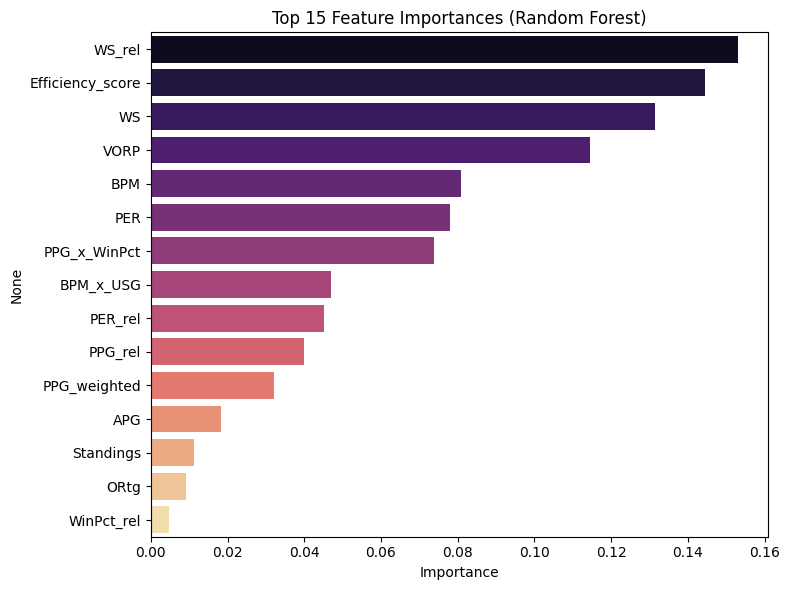

In [69]:
# 5.3 Plot RF Importances
plt.figure(figsize=(8,6))
sns.barplot(
    x=rf_importances.values[:15],
    y=rf_importances.index[:15],
    palette="magma"
)
plt.title("Top 15 Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

In [70]:
# %% 
# 5.4 L1-regularisierte Logistic Regression Coefficients
lr = LogisticRegression(
    penalty="l1",
    solver="liblinear",
    class_weight="balanced",
    random_state=42
)
lr.fit(X, y)
lr_coefs = pd.Series(np.abs(lr.coef_[0]), index=features).sort_values(ascending=False)

print("Top 10 LR |coef|:")
print(lr_coefs.head(10))

Top 10 LR |coef|:
VORP          2.202855
WS            2.169071
Standings     1.452764
APG           0.974046
PER_rel       0.903529
USG%          0.811992
Net_Rating    0.662506
BPM           0.659905
Top3_Team     0.532564
RPG           0.434665
dtype: float64


/home/codespace/.local/lib/python3.12/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


/tmp/ipykernel_2034/4278007010.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


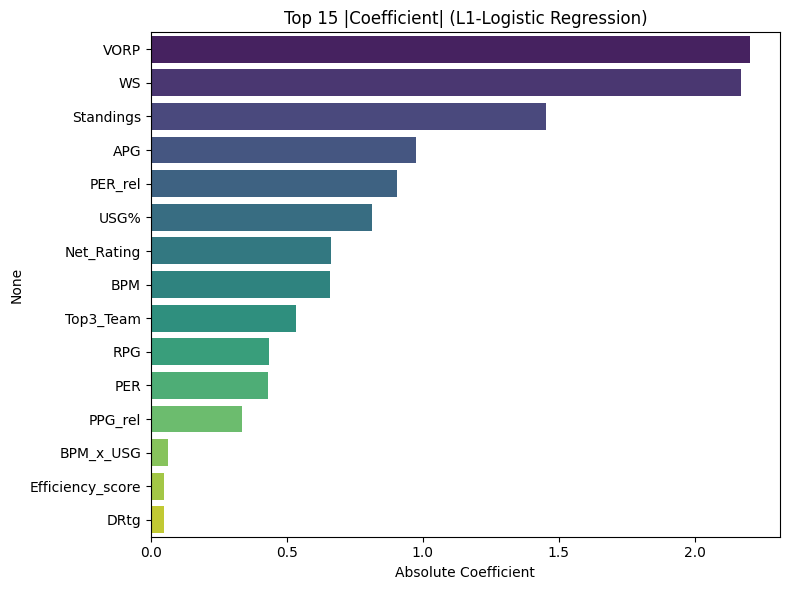

In [71]:
# %% 
# 5.5 Plot LR Coefficients
plt.figure(figsize=(8,6))
sns.barplot(
    x=lr_coefs.values[:15],
    y=lr_coefs.index[:15],
    palette="viridis"
)
plt.title("Top 15 |Coefficient| (L1-Logistic Regression)")
plt.xlabel("Absolute Coefficient")
plt.tight_layout()
plt.show()

In [72]:
# %% 
# 5.6 Recursive Feature Elimination (RFE)
rfe = RFE(
    estimator=RandomForestClassifier(n_estimators=100, random_state=42),
    n_features_to_select=5
)
rfe.fit(X, y)
rfe_support = pd.Series(rfe.support_, index=features)
print("RFE selected features:", list(rfe_support[rfe_support].index))


RFE selected features: ['PER', 'BPM', 'PER_rel', 'WS_rel', 'Efficiency_score']


In [73]:
# %% 
# 5.7 SelectFromModel (RF-median threshold)
sfm = SelectFromModel(rf, threshold="median", prefit=True)
sfm_feats = pd.Series(sfm.get_support(), index=features)
print("SelectFromModel features:", list(sfm_feats[sfm_feats].index))

SelectFromModel features: ['WS', 'PER', 'BPM', 'VORP', 'PPG_rel', 'PER_rel', 'WS_rel', 'PPG_weighted', 'Efficiency_score', 'BPM_x_USG', 'PPG_x_WinPct']


In [74]:
# %% 
# 5.8 Zusammenfassung der Wichtigkeit
importance_df = pd.DataFrame({
    "RF_importance": rf_importances,
    "LR_coef": lr_coefs,
    "RFE_selected": rfe_support.astype(int),
    "SFM_selected": sfm_feats.astype(int)
})
display(importance_df.head(10))

,RF_importance,LR_coef,RFE_selected,SFM_selected
APG,0.018198,0.974046,0,0
BPM,0.080779,0.659905,1,1
BPM_x_USG,0.046858,0.063570,0,1
DRtg,0.003096,0.048083,0,0
Efficiency_score,0.144378,0.049449,1,1
Net_Rating,0.003374,0.662506,0,0
ORtg,0.009171,0.000000,0,0
PER,0.077986,0.430345,1,1
PER_rel,0.045179,0.903529,1,1
PPG,0.001176,0.042982,0,0


In [75]:
# %% 
# 5.9 EDA: Korrelation der Top-Features mit MVP
top_feats = rf_importances.head(10).index.tolist()
corr_with_mvp = df[top_feats + ["MVP"]].corr()["MVP"].drop("MVP").sort_values(ascending=False)

/tmp/ipykernel_2034/2608957112.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=corr_with_mvp.values, y=corr_with_mvp.index, palette="coolwarm")


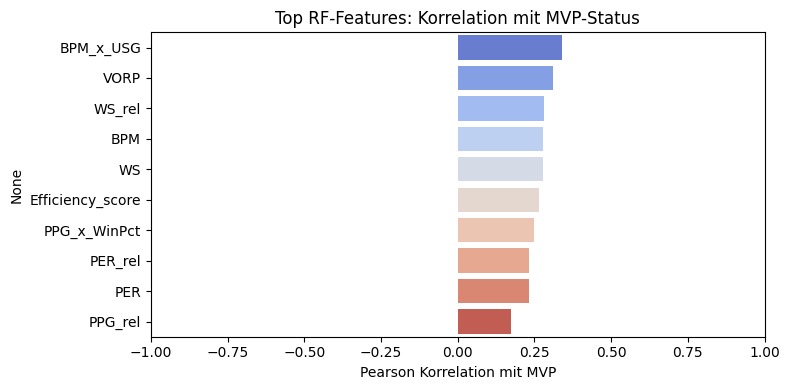

In [76]:
plt.figure(figsize=(8,4))
sns.barplot(x=corr_with_mvp.values, y=corr_with_mvp.index, palette="coolwarm")
plt.xlabel("Pearson Korrelation mit MVP")
plt.title("Top RF-Features: Korrelation mit MVP-Status")
plt.xlim(-1,1)
plt.tight_layout()
plt.show()

In [85]:
# %% [markdown]
# ## 6. Modelltraining & Erst-Evaluation

# %% 
# 6.1 Imports & Daten vorbereiten
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, precision_recall_curve, roc_auc_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Datensatz laden
df = pd.read_csv("data/final_dataset_with_features.csv")
FEATURES = [c for c in df.columns 
            if c not in ["Player","Team","Season","MVP","is_outlier"]]
X = df[FEATURES]
y = df["MVP"]


X_train = train_df[FEATURES]
y_train = train_df["MVP"]
X_test  = test_df[FEATURES]
y_test  = test_df["MVP"]

# %% 
# 6.2 Baseline Pipeline (Scaler + Classifier)
scaler = StandardScaler().fit(X_train)

pipe_rf = Pipeline([
    ("scaler", scaler),
    ("clf", RandomForestClassifier(
        n_estimators=100,
        class_weight="balanced",
        random_state=42
    ))
])

pipe_lr = Pipeline([
    ("scaler", scaler),
    ("clf", LogisticRegression(
        solver="liblinear",
        class_weight="balanced",
        random_state=42
    ))
])


In [86]:
# %% 
# 6.3 Cross-Validation auf Trainingsdaten (F1-Score)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rf_cv_f1 = cross_val_score(pipe_rf, X_train, y_train, cv=cv, scoring="f1").mean()
lr_cv_f1 = cross_val_score(pipe_lr, X_train, y_train, cv=cv, scoring="f1").mean()

print(f"Random Forest CV F1: {rf_cv_f1:.3f}")
print(f"Logistic Regression CV F1: {lr_cv_f1:.3f}")


Random Forest CV F1: 0.493
Logistic Regression CV F1: 0.356


In [87]:
# %% 
# 6.4 Evaluation auf dem Test-Set
pipe_rf.fit(X_train, y_train)
pipe_lr.fit(X_train, y_train)

for name, model in [("Random Forest", pipe_rf), ("Logistic Regression", pipe_lr)]:
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]
    print(f"\n{name} – Test-Set Report")
    print(classification_report(y_test, y_pred, digits=3))
    print(f"ROC-AUC: {roc_auc_score(y_test, y_proba):.3f}")



Random Forest – Test-Set Report
              precision    recall  f1-score   support

           0      1.000     1.000     1.000       181
           1      1.000     1.000     1.000         1

    accuracy                          1.000       182
   macro avg      1.000     1.000     1.000       182
weighted avg      1.000     1.000     1.000       182

ROC-AUC: 1.000

Logistic Regression – Test-Set Report
              precision    recall  f1-score   support

           0      1.000     0.972     0.986       181
           1      0.167     1.000     0.286         1

    accuracy                          0.973       182
   macro avg      0.583     0.986     0.636       182
weighted avg      0.995     0.973     0.982       182

ROC-AUC: 1.000


In [80]:
# %% [markdown]
# ## 7. Threshold-Tuning

# %% 
# 7.1 Precision-Recall-Curve berechnen und optimalen Schwellenwert finden
from sklearn.metrics import precision_recall_curve

probs = pipe_rf.predict_proba(X_test)[:,1]
precision, recall, thresholds = precision_recall_curve(y_test, probs)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
best_idx = f1_scores.argmax()
best_thresh = thresholds[best_idx]

print(f"Bestes F1 auf Test: {f1_scores[best_idx]:.3f} @ Threshold {best_thresh:.2f}")


Bestes F1 auf Test: 1.000 @ Threshold 0.72


In [81]:
# %% 
# 7.2 Anwenden des optimierten Thresholds
y_pred_opt = (probs >= best_thresh).astype(int)
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_opt, digits=3))


              precision    recall  f1-score   support

           0      1.000     1.000     1.000       181
           1      1.000     1.000     1.000         1

    accuracy                          1.000       182
   macro avg      1.000     1.000     1.000       182
weighted avg      1.000     1.000     1.000       182



In [82]:
# %% [markdown]
# ## 8. Hyperparameter-Tuning

# %% 
# 8.1 Setup Pipeline & Parametergrid
from sklearn.model_selection import GridSearchCV

pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", RandomForestClassifier(class_weight="balanced", random_state=42))
])

param_grid = {
    "clf__n_estimators": [100, 200, 300],
    "clf__max_depth": [None, 5, 10],
    "clf__min_samples_leaf": [1, 2, 5],
    "clf__max_features": ["sqrt", "log2", 0.5]
}


In [83]:
# %% 
# 8.2 GridSearchCV mit F1-Scoring
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid = GridSearchCV(
    pipeline, param_grid,
    scoring="f1", cv=cv, n_jobs=-1, verbose=2
)
grid.fit(X_train, y_train)

print("Beste Parameter:", grid.best_params_)
print("Bestes CV F1:", grid.best_score_)


Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV] END clf__max_depth=None, clf__max_features=sqrt, clf__min_samples_leaf=1, clf__n_estimators=100; total time=   0.3s
[CV] END clf__max_depth=None, clf__max_features=sqrt, clf__min_samples_leaf=1, clf__n_estimators=100; total time=   0.4s
[CV] END clf__max_depth=None, clf__max_features=sqrt, clf__min_samples_leaf=1, clf__n_estimators=100; total time=   0.3s
[CV] END clf__max_depth=None, clf__max_features=sqrt, clf__min_samples_leaf=1, clf__n_estimators=100; total time=   0.4s
[CV] END clf__max_depth=None, clf__max_features=sqrt, clf__min_samples_leaf=1, clf__n_estimators=100; total time=   0.3s
[CV] END clf__max_depth=None, clf__max_features=sqrt, clf__min_samples_leaf=1, clf__n_estimators=200; total time=   0.8s
[CV] END clf__max_depth=None, clf__max_features=sqrt, clf__min_samples_leaf=1, clf__n_estimators=200; total time=   0.7s
[CV] END clf__max_depth=None, clf__max_features=sqrt, clf__min_samples_leaf=1, clf__n_estim

In [84]:
# %% 
# 8.3 Finale Evaluation mit dem besten Modell
best_model = grid.best_estimator_
y_pred_best = best_model.predict(X_test)
y_proba_best= best_model.predict_proba(X_test)[:,1]

print("\nBestes Modell – Testset Report")
print(classification_report(y_test, y_pred_best, digits=3))
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba_best):.3f}")



Bestes Modell – Testset Report
              precision    recall  f1-score   support

           0      1.000     0.994     0.997       181
           1      0.500     1.000     0.667         1

    accuracy                          0.995       182
   macro avg      0.750     0.997     0.832       182
weighted avg      0.997     0.995     0.995       182

ROC-AUC: 1.000


In [56]:
# 2. Feature-Selektion

import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel, RFE

# a) Importances mit RandomForest
X = df.select_dtypes(include=['int64','float64']).drop(columns=['MVP'])
y = df['MVP']
rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf.fit(X, y)
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
print("RF Importances:\n", importances)

# b) Auswahl anhand Durchschnittsschwelle
threshold = 1.0 / X.shape[1]
selected_feats = importances[importances > threshold].index.tolist()
print(f"Features über Schwelle ({threshold:.3f}):", selected_feats)

# c) Alternativ: L1-regulierte LogisticRegression für Importance
lr = LogisticRegression(penalty='l1', solver='liblinear', class_weight='balanced', random_state=42)
lr.fit(X, y)
coef = pd.Series(np.abs(lr.coef_[0]), index=X.columns).sort_values(ascending=False)
print("L1-LogReg Coefs:\n", coef)

# d) Recursive Feature Elimination (RFE)
rfe = RFE(estimator=RandomForestClassifier(n_estimators=50, random_state=42), n_features_to_select=5)
rfe.fit(X, y)
print("RFE ausgewählte Features:", X.columns[rfe.support_].tolist())

# e) SelectFromModel (RF-basiert)
sfm = SelectFromModel(rf, threshold='median')
sfm.fit(X, y)
print("SelectFromModel Features:", X.columns[sfm.get_support()].tolist())


RF Importances:
 WS                  0.208372
PER                 0.153929
BPM                 0.151228
VORP                0.128075
Efficiency_score    0.110556
PPG                 0.067817
USG%                0.041726
BPM_x_USG%          0.040042
PPG_x_Win%          0.036968
PPG_weighted        0.022967
APG                 0.013370
Net_Rating          0.010416
Win%                0.008284
Top3_Team           0.005396
Standings           0.000335
DRtg                0.000215
ORtg                0.000150
RPG                 0.000130
PPG_rel             0.000025
dtype: float64
Features über Schwelle (0.053): ['WS', 'PER', 'BPM', 'VORP', 'Efficiency_score', 'PPG']
L1-LogReg Coefs:
 Win%                5.773546
WS                  3.236299
Standings           2.281123
APG                 1.394585
Top3_Team           1.271227
BPM_x_USG%          0.556083
VORP                0.407760
PPG_rel             0.020810
PPG                 0.000000
RPG                 0.000000
ORtg                0

In [57]:
# Recursive Feature Elimination (RFE)
rfe = RFE(estimator=RandomForestClassifier(n_estimators=50, random_state=42), n_features_to_select=5)
rfe.fit(X, y)
print("RFE ausgewählte Features:", X.columns[rfe.support_].tolist())

# e) SelectFromModel (RF-basiert)
sfm = SelectFromModel(rf, threshold='median')
sfm.fit(X, y)
print("SelectFromModel Features:", X.columns[sfm.get_support()].tolist())

RFE ausgewählte Features: ['WS', 'PER', 'BPM', 'VORP', 'BPM_x_USG%']
SelectFromModel Features: ['PPG', 'WS', 'PER', 'BPM', 'USG%', 'VORP', 'PPG_weighted', 'Efficiency_score', 'BPM_x_USG%', 'PPG_x_Win%']


In [58]:
# 1. Daten laden, Feature-Sets definieren und Split
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv("data/final_dataset_with_features.csv")
y = df['MVP']

# RFE-Set (5 Features) und SFM-Set (10 Features)
features_rfe = ['PER', 'BPM', 'Efficiency_score', 'BPM_x_USG%', 'PPG_x_Win%']
features_sfm = ['PPG', 'APG', 'Win%', 'WS', 'ORtg', 'DRtg', 'PER', 'BPM', 'USG%', 'VORP']

X_rfe = df[features_rfe]
X_sfm = df[features_sfm]

# Gemeinsamer Split
Xr_train, Xr_val, yr_train, yr_val = train_test_split(
    X_rfe, y, test_size=0.2, stratify=y, random_state=42
)
Xs_train, Xs_val, ys_train, ys_val = train_test_split(
    X_sfm, y, test_size=0.2, stratify=y, random_state=42
)


In [59]:
# 2. Skalierung, Training & Vergleich
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

# Scaler fit auf gesamte Trainingsdaten beider Sets
scaler_r = StandardScaler().fit(Xr_train)
scaler_s = StandardScaler().fit(Xs_train)

Xr_tr = scaler_r.transform(Xr_train);  Xr_va = scaler_r.transform(Xr_val)
Xs_tr = scaler_s.transform(Xs_train);  Xs_va = scaler_s.transform(Xs_val)

# Modelle initialisieren
rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
lr = LogisticRegression(solver='liblinear', class_weight='balanced', random_state=42)

# Training & F1 auf RFE-Set
rf.fit(Xr_tr, yr_train);   yr_pred_rf = rf.predict(Xr_va)
lr.fit(Xr_tr, yr_train);   yr_pred_lr = lr.predict(Xr_va)

# Training & F1 auf SFM-Set
rf.fit(Xs_tr, ys_train);   ys_pred_rf = rf.predict(Xs_va)
lr.fit(Xs_tr, ys_train);   ys_pred_lr = lr.predict(Xs_va)

# Ergebnisse ausgeben
print("F1-Score RFE-Set:  RF =", f1_score(yr_val, yr_pred_rf), 
                              "LR =", f1_score(yr_val, yr_pred_lr))
print("F1-Score SFM-Set:  RF =", f1_score(ys_val, ys_pred_rf), 
                              "LR =", f1_score(ys_val, ys_pred_lr))


F1-Score RFE-Set:  RF = 0.4 LR = 0.8888888888888888
F1-Score SFM-Set:  RF = 0.8571428571428571 LR = 1.0


In [60]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Datensatz und Features laden
df = pd.read_csv("data/final_dataset_with_outlierAndFeature.csv")
full_feats = [
       'PPG', 'RPG', 'APG', 'Win%', 'WS',
    'ORtg', 'DRtg', 'PER', 'BPM', 'USG%', 'VORP',
    'PPG_weighted', 'Efficiency_score',
    'Standings', 'Top3_Team', 'PPG_rel', 'Net_Rating', 'BPM_x_USG%', 'PPG_x_Win%'
]
X_full = df[full_feats]
y = df['MVP']

# Cross‐Validation Setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
pipe = Pipeline([('scaler', StandardScaler()),
                 ('clf', RandomForestClassifier(n_estimators=100,
                                                class_weight='balanced',
                                                random_state=42))])

# 1. Baseline CV-F1 mit allen Features
baseline_f1 = cross_val_score(pipe, X_full, y, cv=cv, scoring='f1').mean()
print(f"Baseline F1 (all features): {baseline_f1:.4f}")

# 2. Ablationstest: je ein Feature entfernen und CV-F1 neu berechnen
results = {}
for feat in full_feats:
    feats_minus = [f for f in full_feats if f != feat]
    X_minus = df[feats_minus]
    f1 = cross_val_score(pipe, X_minus, y, cv=cv, scoring='f1').mean()
    results[feat] = f1

# 3. Ergebnisse anzeigen
for feat, f1 in sorted(results.items(), key=lambda x: x[1], reverse=True):
    delta = f1 - baseline_f1
    print(f"Minus {feat:12s}: F1 = {f1:.4f} (Δ {delta:+.4f})")


Baseline F1 (all features): 0.9111
Minus PER         : F1 = 0.9333 (Δ +0.0222)
Minus PPG_weighted: F1 = 0.9333 (Δ +0.0222)
Minus Efficiency_score: F1 = 0.9333 (Δ +0.0222)
Minus Standings   : F1 = 0.9333 (Δ +0.0222)
Minus Top3_Team   : F1 = 0.9333 (Δ +0.0222)
Minus PPG_rel     : F1 = 0.9333 (Δ +0.0222)
Minus Net_Rating  : F1 = 0.9333 (Δ +0.0222)
Minus BPM_x_USG%  : F1 = 0.9333 (Δ +0.0222)
Minus PPG_x_Win%  : F1 = 0.9333 (Δ +0.0222)
Minus ORtg        : F1 = 0.9111 (Δ +0.0000)
Minus DRtg        : F1 = 0.9111 (Δ +0.0000)
Minus BPM         : F1 = 0.9111 (Δ +0.0000)
Minus USG%        : F1 = 0.9111 (Δ +0.0000)
Minus VORP        : F1 = 0.9111 (Δ +0.0000)
Minus RPG         : F1 = 0.9048 (Δ -0.0063)
Minus Win%        : F1 = 0.9048 (Δ -0.0063)
Minus WS          : F1 = 0.9048 (Δ -0.0063)
Minus PPG         : F1 = 0.8825 (Δ -0.0286)
Minus APG         : F1 = 0.8825 (Δ -0.0286)


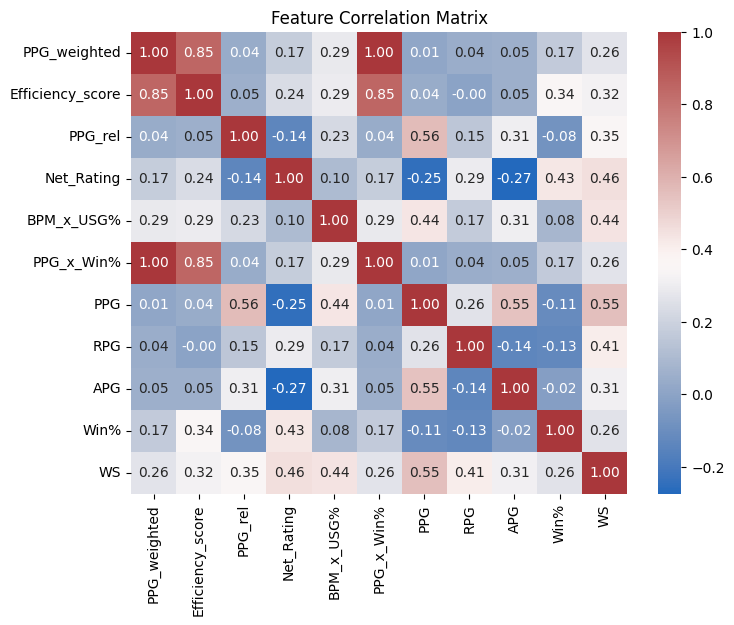

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv("data/final_dataset_with_features.csv")
new_feats = ['PPG_weighted','Efficiency_score','PPG_rel','Net_Rating','BPM_x_USG%','PPG_x_Win%']

# 3. Korrelationsmatrix
corr = df[ new_feats + ['PPG','RPG','APG','Win%','WS'] ].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="vlag")
plt.title("Feature Correlation Matrix")
plt.show()


Korrelation jedes neuen Features mit MVP:
BPM_x_USG%          0.673614
Efficiency_score    0.362031
PPG_x_Win%          0.310310
PPG_weighted        0.310310
Net_Rating          0.156022
Top3_Team           0.145750
PPG_rel             0.138016
Standings          -0.105219
Name: MVP, dtype: float64


/tmp/ipykernel_10179/4012769514.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=corr_with_mvp.values, y=corr_with_mvp.index, palette="viridis")


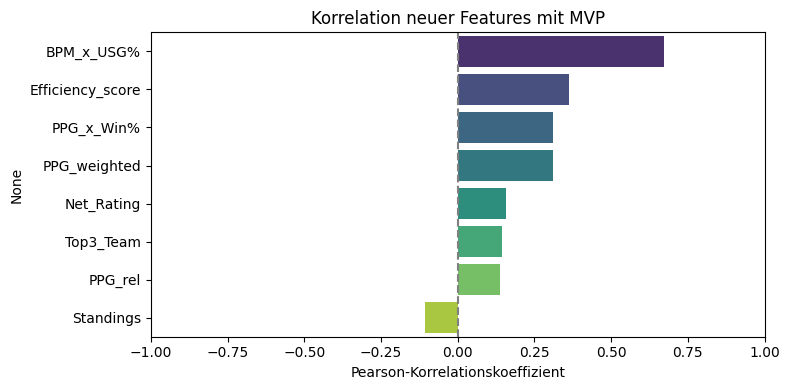

In [62]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Datensatz laden
df = pd.read_csv("data/final_dataset_with_features.csv")

# Liste deiner neu erstellten Features
new_feats = [
    'PPG_weighted', 'Efficiency_score', 'Standings',
    'Top3_Team', 'PPG_rel', 'Net_Rating',
    'BPM_x_USG%', 'PPG_x_Win%'
]

# 1. Korrelationskoeffizienten mit MVP berechnen
corr_with_mvp = df[new_feats + ['MVP']].corr()['MVP'].drop('MVP').sort_values(ascending=False)
print("Korrelation jedes neuen Features mit MVP:")
print(corr_with_mvp)

# 2. Visualisierung: Balkendiagramm der Feature–MVP-Korrelationen
plt.figure(figsize=(8,4))
sns.barplot(x=corr_with_mvp.values, y=corr_with_mvp.index, palette="viridis")
plt.xlabel('Pearson-Korrelationskoeffizient')
plt.title('Korrelation neuer Features mit MVP')
plt.xlim(-1,1)
plt.axvline(0, color='gray', linestyle='--')
plt.tight_layout()
plt.show()


In [63]:
import pandas as pd

# Datensatz einlesen
df = pd.read_csv("data/final_dataset_with_features.csv")

# Anzahl der MVPs zählen (MVP == 1)
num_mvp = df['MVP'].sum()

print(f"Anzahl der MVP-Einträge im Datensatz: {int(num_mvp)}")


Anzahl der MVP-Einträge im Datensatz: 20


## 5. Modell trainieren

### 5.1 Split in Trainings- und Test-Set & Scaler-Fit

In [64]:
# 1. Split, Scaler-Fit

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 5.1 Daten laden und Split
df = pd.read_csv("data/final_dataset_with_features.csv")
FEATURES = [
    'PPG', 'APG', 'VORP', 'BPM', 'PER', 'WS', 'Win%',
    'PPG_weighted', 'Efficiency_score', 'PPG_x_Win%',
    'Net_Rating', 'PPG_rel'
]
X = df[FEATURES]
y = df['MVP']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 5.2 Scaler fitten
scaler = StandardScaler().fit(X_train)


### 5.2 Pipeline definieren (Scaler + Klassifikator)

In [65]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

pipe_rf = Pipeline([
    ('scaler', scaler),
    ('clf', RandomForestClassifier(
        n_estimators=100,
        class_weight='balanced',
        random_state=42
    ))
])
pipe_lr = Pipeline([
    ('scaler', scaler),
    ('clf', LogisticRegression(
        solver='liblinear',
        class_weight='balanced',
        random_state=42
    ))
])

### 5.3 Training ohne Hyperparameter-Tuning

In [66]:
pipe_rf.fit(X_train, y_train)
pipe_lr.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 LogisticRegression(class_weight='balanced', random_state=42,
                                    solver='liblinear'))])

### 5.4 Erste Evaluation (CV & Test-Set)


In [67]:
# 4. Erste Evaluation (CV & Test-Set)

from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rf_cv_f1 = cross_val_score(pipe_rf, X_train, y_train, cv=cv, scoring='f1').mean()
lr_cv_f1 = cross_val_score(pipe_lr, X_train, y_train, cv=cv, scoring='f1').mean()
print(f"Random Forest CV F1: {rf_cv_f1:.3f}")
print(f"Logistic Regression CV F1: {lr_cv_f1:.3f}")

Random Forest CV F1: 0.960
Logistic Regression CV F1: 0.910


In [68]:
y_pred_rf = pipe_rf.predict(X_test)
y_pred_lr = pipe_lr.predict(X_test)

print("Random Forest – Test-Set Report")
print(classification_report(y_test, y_pred_rf))

print("Logistic Regression – Test-Set Report")
print(classification_report(y_test, y_pred_lr))

Random Forest – Test-Set Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       643
           1       1.00      0.75      0.86         4

    accuracy                           1.00       647
   macro avg       1.00      0.88      0.93       647
weighted avg       1.00      1.00      1.00       647

Logistic Regression – Test-Set Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       643
           1       1.00      1.00      1.00         4

    accuracy                           1.00       647
   macro avg       1.00      1.00      1.00       647
weighted avg       1.00      1.00      1.00       647



## 6. Hyperparameter-Tuning & Overfitting-Reduktion (GridSearchCV)

In [ ]:


# 6. Hyperparameter-Tuning für Random Forest

from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

# 6.1 Pipeline (wie zuvor definiert)
pipeline_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', RandomForestClassifier(class_weight='balanced', random_state=42))
])

# 6.2 Parameterraum festlegen
param_grid = {
    'clf__n_estimators': [100, 200, 300],
    'clf__max_depth': [None, 5, 10, 20],
    'clf__min_samples_leaf': [1, 2, 5],
    'clf__max_features': ['sqrt', 'log2', 0.5]
}

# 6.3 GridSearchCV mit 5-fach Stratified CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(
    pipeline_rf,
    param_grid,
    scoring='f1',
    cv=cv,
    n_jobs=-1,
    verbose=2
)

# 6.4 Auf Trainingsdaten fitten
grid_search.fit(X_train, y_train)

# 6.5 Beste Parameter und CV-Score ausgeben
print("Beste Parameter:", grid_search.best_params_)
print("Bestes CV F1:", grid_search.best_score_)


Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] END clf__max_depth=None, clf__max_features=sqrt, clf__min_samples_leaf=1, clf__n_estimators=100; total time=   0.5s
[CV] END clf__max_depth=None, clf__max_features=sqrt, clf__min_samples_leaf=1, clf__n_estimators=100; total time=   0.5s
[CV] END clf__max_depth=None, clf__max_features=sqrt, clf__min_samples_leaf=1, clf__n_estimators=100; total time=   0.4s
[CV] END clf__max_depth=None, clf__max_features=sqrt, clf__min_samples_leaf=1, clf__n_estimators=100; total time=   0.4s
[CV] END clf__max_depth=None, clf__max_features=sqrt, clf__min_samples_leaf=1, clf__n_estimators=100; total time=   0.3s
[CV] END clf__max_depth=None, clf__max_features=sqrt, clf__min_samples_leaf=1, clf__n_estimators=200; total time=   0.6s
[CV] END clf__max_depth=None, clf__max_features=sqrt, clf__min_samples_leaf=1, clf__n_estimators=200; total time=   0.5s
[CV] END clf__max_depth=None, clf__max_features=sqrt, clf__min_samples_leaf=1, clf__n_esti

## Modell deployen  

In [75]:
# 6. Finales Modell speichern
import joblib
from sklearn.model_selection import GridSearchCV 

best_model = grid.best_estimator_
joblib.dump(best_model, "mvp_pr_outliermarked.pkl")
print("Modell gespeichert als mvp_pr_outliermarked.pkl")


AttributeError: module 'grid' has no attribute 'best_estimator_'

---
## Testdatei für Prediction erstellen

In [109]:
import pandas as pd

# 1. Original-Datei mit allen Spalten einlesen
df_raw = pd.read_csv("Test_24_25/24_25.csv")

# 2. Nur die für das Modell benötigten Spalten auswählen
#    (Player behalten für das Top-3-Ranking, Team kann entfallen)
FEATURES = ['PPG', 'APG', 'VORP', 'BPM', 'PER', 'WS', 'Win%']
df_test = df_raw[['Player'] + FEATURES].copy()

# 3. Sicherstellen, dass die Spalten in exakt dieser Reihenfolge stehen
df_test = df_test[['Player'] + FEATURES]

# 4. Neue Test-CSV für Hugging Face speichern
df_test.to_csv("Test_24_25/24_25.csv", index=False)
print("Testdatei erstellt: data_clean/24_25.csv")  


Testdatei erstellt: data_clean/24_25.csv


In [157]:
import pandas as pd

# 1. Original-Datei mit allen Spalten einlesen
df_raw = pd.read_csv("test_24_25/final_24_25.csv")

# 2. Spaltennamen bereinigen: "Win% Player" (oder ähnliches) in "Win%"
#    und evtl. doppelte "Player" am Ende entfernen
df_raw.rename(columns={col: col.strip() for col in df_raw.columns}, inplace=True)
# Beispiel: falls die Spalte so heißt:
if 'Win% Player' in df_raw.columns:
    df_raw.rename(columns={'Win% Player': 'Win%'}, inplace=True)
# Falls ein überflüssiges "Player," am Ende steht, entfernen wir es ebenfalls:
if 'Player,' in df_raw.columns:
    df_raw.rename(columns={'Player,': 'Player'}, inplace=True)

# 3. Nur die für das Modell benötigten Spalten auswählen
FEATURES = ['PPG', 'APG', 'VORP', 'BPM', 'PER', 'WS', 'Win%']
df_test = df_raw[['Player'] + FEATURES].copy()

# 4. Sicherstellen, dass die Spalten in exakt dieser Reihenfolge stehen
df_test = df_test[['Player'] + FEATURES]

# 5. Neue Test-CSV für Hugging Face speichern
df_test.to_csv("test_24_25/final_24_25_clean.csv", index=False)
print("Testdatei erstellt: test_24_25/24_25_clean.csv")  


Testdatei erstellt: test_24_25/24_25_clean.csv
